# Import our modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import os
from scipy import ndimage # multidimensional image processing

### Change run time to gpu
Tools -> Runtime -> GPU

# Mount to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get images and process


In [ ]:
test_images=[]
test_labels = []

data_path = '/content/drive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/'

dataset = list(os.listdir(data_path))          
dataset.sort()
print(dataset)
# there are 32 images in our validation dataset with associated txt files that contain the position of the detected apples
for i in range(32):
  # Now order is sorted, we just want to take the even ones as these are the png images.
  img_name = data_path  + dataset[2*i]
  # the odd ones are the corresponding labels
  img_label = data_path + dataset [2*i + 1]
  print("name: " + img_name)
  print("label: " + img_label)

  test_images.append(img_name)
  test_labels.append(img_label)

# Apply our colour filter to Remove "non-red" ixels
### cropping out the floor - splitting - filtering - merging back the image

In [ ]:
def split_img(img):#splits the main image into 10 smaller images
    coordy=np.linspace(0,img.shape[0],6).astype(int)
    coordx=np.linspace(0,img.shape[1],3).astype(int)
    list_im=[]
    for n in range((len(coordy)-1)*(len(coordx)-1)):
        im_s=img[coordy[n//2]:coordy[(n//2)+1],coordx[n%2]:coordx[(n%2)+1]]

        list_im.append(im_s)
    return list_im

def thresh_weight(im):#im: the image to filter. return a black and white filtered image (apples in white)
    im2=np.zeros(im.shape)
    w=np.sum(im[:,:,1])/(np.sum(im[:,:,:])+np.sum(im[:,:,1])) #calculate the threshold
    for i in range (im2.shape[0]):
        for j in range (im2.shape[1]):
            sum=np.sum(im[i,j])
            if sum > 0 and (im[i,j,1]/sum)<w:
              im2[i,j]=[1,1,1]
    return im2

    
def split_filter(list):#list of the filtered images
    list_filt=[]
    for i in list:
        list_filt.append(thresh_weight(i))
    return list_filt
    
    
def merge(list,img):#merge the images from the list into an image the size of the original one
    coordy=np.linspace(0,img.shape[0],6).astype(int)
    coordx=np.linspace(0,img.shape[1],3).astype(int)
    im_merged=np.zeros((coordy[-1],coordx[-1],3))
    for n in range(len(list)):
        im_merged[coordy[n//2]:coordy[(n//2)+1],coordx[n%2]:coordx[(n%2)+1]]=list[n]
    return im_merged
    
def full_filtering_operations(img):# perform the whole split-filter-merge sequence (returns the whole filtered and cropped image)
    img=img[:round(img.shape[0]*0.83),:,:]#crop out the floor
    list_im=split_img(img)
    list_filt=split_filter(list_im)
    im_merged=merge(list_filt,img)
    return im_merged

# Perform Opening and Erosion

[[1 1 1]
 [1 1 1]
 [1 1 1]]


Text(0.5, 1.0, 'opening & erosion')

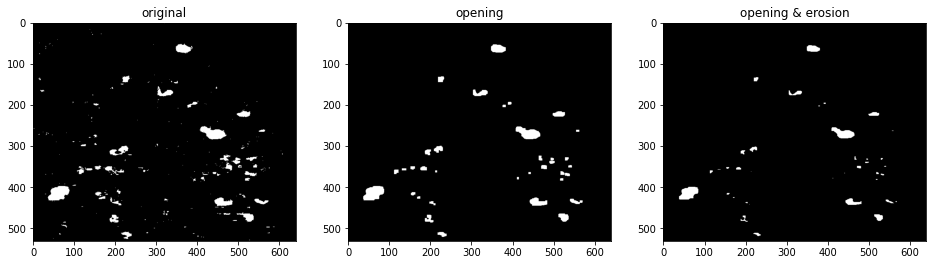

In [ ]:
demo_image = test_images[0]


test = full_filtering_operations(mpimg.imread(demo_image))
kernel = np.ones((3,3),np.uint8) # this shows us we are using 8 adjacent as we have a centre pixel surrounded by 8.
print(kernel)
opening = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel, iterations=2)
# erosion - for a pixel that is surrounded by black pixels, remove all the surrounding
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosion = cv2.erode(opening,kernel,iterations = 2)


plt.figure(figsize=(16, 12))
plt.subplot(2,3,1)
plt.imshow(test)
plt.title("original")
plt.subplot(2,3,2)
plt.imshow(opening)
plt.title("opening")
plt.subplot(2,3,3)
plt.imshow(erosion)
plt.title("opening & erosion")

### Above, select which round produced the best result, use it below to mark the apples.

# Find the centroid of each apple

37 , Apples have been detected
32 , Apples are labelled
115.6% of apples have been detected


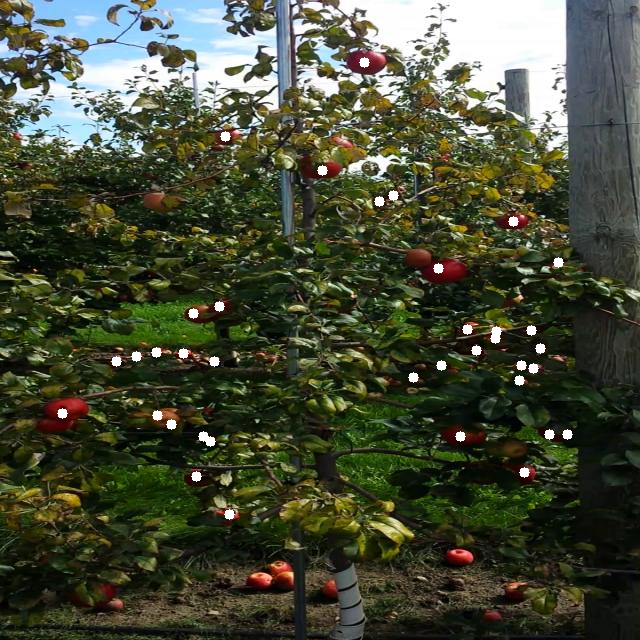

In [ ]:
display = cv2.imread(demo_image)
labels, nlabels = ndimage.label(erosion)  # Label features in an array. Any non-zero values in input are counted as features and zero values are considered the background.
print( str(nlabels) + " , Apples have been detected")


centroid = ndimage.center_of_mass(erosion, labels, np.arange(nlabels) +1 ) # calculate the center of mass of the values of an array at labels.

# draw circles representing the centroids
for cen in centroid:
  display = cv2.circle(display, (cen[1].astype(int), cen[0].astype(int)), radius=5, color=(255, 255, 255), thickness=-1)


# Retrieve labelled number of apples in the photo
label = open(test_labels[0])
NumberOfApples = len(label.readlines())
print(str(NumberOfApples) + " , Apples are labelled")
print(str(round(nlabels/NumberOfApples,3)*100) + "% of apples have been detected")




cv2_imshow(display)


# Next Steps
- create loops to run the code on the rest of the apples and just output the numbers, not images.


In [ ]:
for i in range(len(test_images)):
  # Select Image
  test = full_filtering_operations(mpimg.imread(test_images[i]))

  # Perform Opening, then eroision
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel, iterations=2)
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  erosion = cv2.erode(opening,kernel,iterations = 4)

  # count the number of apples detected
  labels, nlabels = ndimage.label(erosion)  # Label features in an array. Any non-zero values in input are counted as features and zero values are considered the background.

  # Retrieve labelled number of apples in the photo, print detected number, label number and % detected
  label = open(test_labels[i])
  NumberOfApples = len(label.readlines())
  print("for image: " + test_images[i])
  print( str(nlabels) + " , Apples have been detected")
  print(str(NumberOfApples) + " , Apples are labelled")
  print(str(round(nlabels/NumberOfApples,3)*100) + "% of apples have been detected")
  print("\n")

for image: /content/drive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/dataset1_back_1081_png.rf.61ad8a45c7a6cfefce41e0ae4aa209f1.jpg
21 , Apples have been detected
32 , Apples are labelled
65.60000000000001% of apples have been detected


for image: /content/drive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/dataset1_back_1141_png.rf.0216021bb8e9179983fb45da0c6fa934.jpg
21 , Apples have been detected
36 , Apples are labelled
58.3% of apples have been detected


for image: /content/drive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/dataset1_back_301_png.rf.ab9701d9c6a849627fce81f64d5105c7.jpg
30 , Apples have been detected
25 , Apples are labelled
120.0% of apples have been detected


for image: /content/drive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/dataset1_back_991_png.rf.5626aedb831e06

KeyboardInterrupt: ignored